# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction-to-Outlier-Mitigation" data-toc-modified-id="Introduction-to-Outlier-Mitigation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction to Outlier Mitigation</a></div><div class="lev2 toc-item"><a href="#Making-the-data" data-toc-modified-id="Making-the-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Making the data</a></div><div class="lev1 toc-item"><a href="#Mitigating-outliers" data-toc-modified-id="Mitigating-outliers-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Mitigating outliers</a></div><div class="lev2 toc-item"><a href="#Spearman-Regression" data-toc-modified-id="Spearman-Regression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Spearman Regression</a></div><div class="lev1 toc-item"><a href="#Bayesian-approaches-to-outlier-mitigation" data-toc-modified-id="Bayesian-approaches-to-outlier-mitigation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bayesian approaches to outlier mitigation</a></div>

# Introduction to Outlier Mitigation

Welcome to our brief tutorial on the Bayesian theorem and why to use it to perform linear regressions. First, we will provide a motivational example with synthetic data, showing how usual least-squares would do, and then we will introduce Bayes to perform a robust regression.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy as scipy

from matplotlib import rc

# set to use tex, but make sure it is sans-serif fonts only
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# bayes and mcmc
import pymc3 as pm
import theano

# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

## Making the data

First, we will make some data for us to use. 

I will draw 30 points evenly (**not randomly**) from 0 to 10.

In [2]:
x = np.linspace(0, 10, 30)


We will also need some data to plot on the Y-axis. I will draw 30 points between 0 to 10 and I will add just a little bit of noise to most of them. We will replace a random 3 points with outliers

In [3]:
y = np.linspace(0, 10, 30)
y = y + np.random.normal(0, 0.5, len(y))
y[np.random.randint(0, 30, 3)] = np.random.normal(50, 5, 3)

Let's take a look at our data:

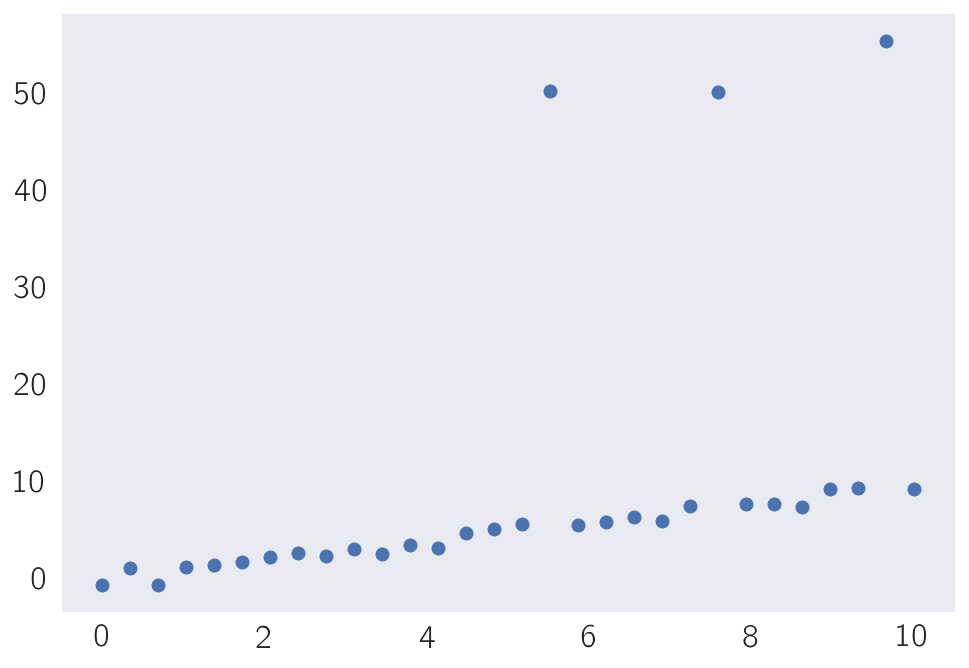

In [4]:
plt.plot(x, y, 'o')

Our data looks pretty good. and we might think that we can calculate a line of best fit. I will use the least-squares algorithm, which is how most lines of best fit are calculated.

In [5]:
def line(x, a, b):
    """The line of best fit."""
    # unpack the parameters:
    y = a + b*x
    
    return y

Perform the optimization

In [6]:
popt, pcov = scipy.optimize.curve_fit(line, x, y)

# unpack the parameters of the line of best fit:
a, b = popt

Let's see the fit:

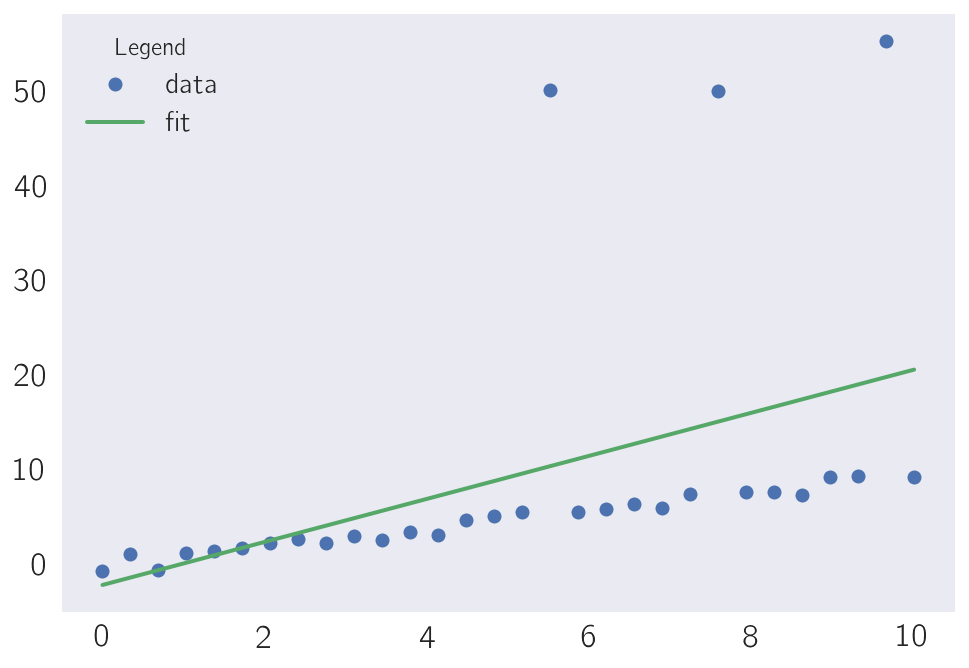

In [7]:
plt.plot(x, y, 'o', label='data')
plt.plot(x, line(x, a, b), label='fit')
plt.legend(title='Legend')

Clearly the fit is not very good. Our eyes can see a better trendline, if only we could ignore the outliers. 

# Mitigating outliers

One common approach towards mitigating outliers is to rank the points. Let's see what happens when we do this.

In [8]:
x_ranked = scipy.stats.rankdata(x)
y_ranked = scipy.stats.rankdata(y)

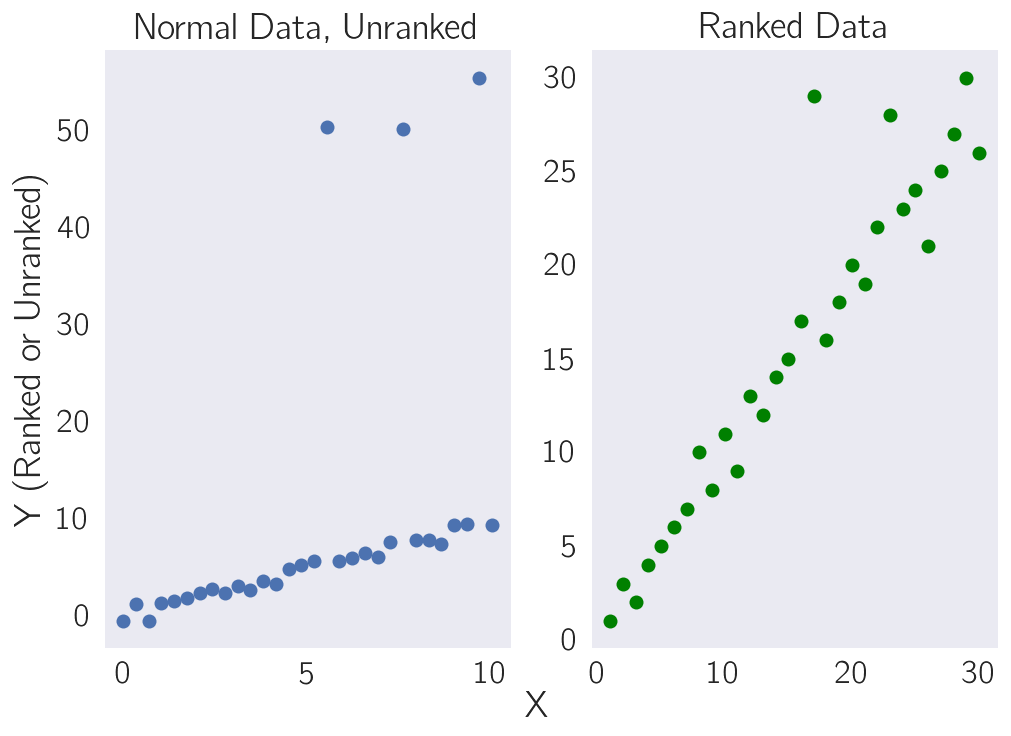

In [9]:
fig, ax = plt.subplots(ncols=2, sharey=False)

ax[0].plot(x, y, 'o')
ax[0].set_title('Normal Data, Unranked')
ax[1].plot(x_ranked, y_ranked, 'go')
ax[1].set_title('Ranked Data')

ax[0].set_ylabel('Y (Ranked or Unranked)')
fig.text(0.5, 0.04, 'X', ha='center', size=18)


## Spearman Regression

Clearly ranking the data mitigates the outliers. This is because rank-transformations are insensitive to the distance from the outliers to the mean trend. They don't care how far away the outliers are, they just care about what their rank order is, and the rank order has to have a more compressed space than the unranked points. In this case, the points can vary from 0 to 60 along the y-axis, but the ranked y-axis can only vary from 0 to 30. Effectively, the distance from the main trend to the outliers is cut in half for this example. 

Let's go ahead and find the line of best fit for the ranked data and plot it. Doing this is called a **Spearman regression**

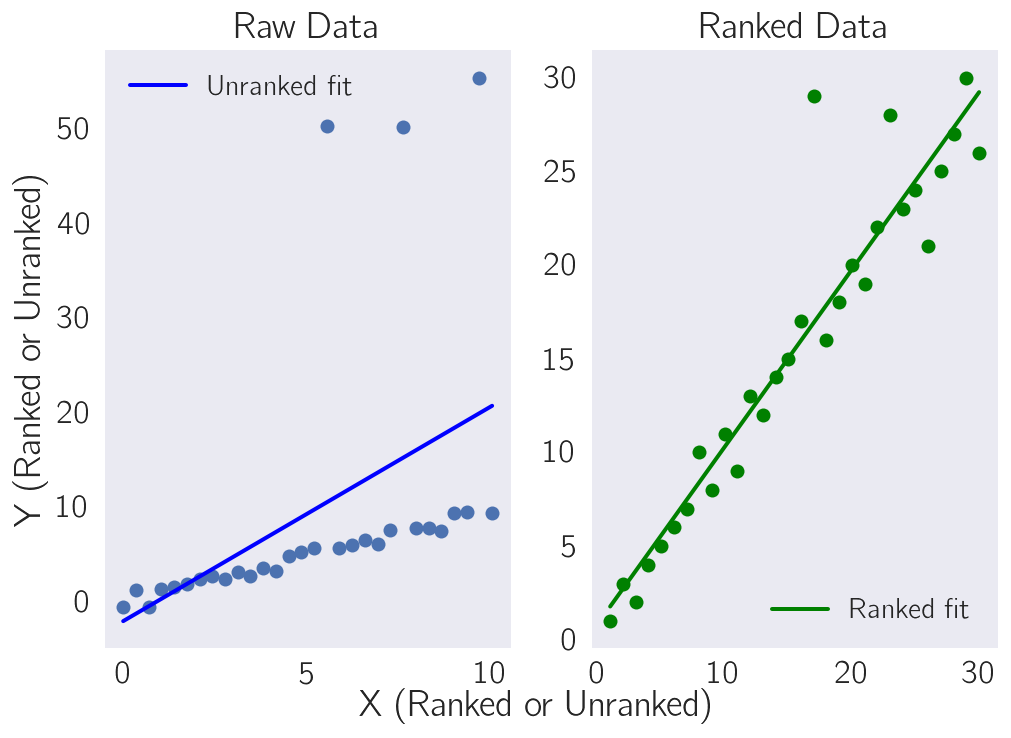

In [10]:
popt, pcov = scipy.optimize.curve_fit(line, x_ranked, y_ranked)
# unpack the parameters of the line of best fit:
arank, brank = popt

# plot
fig, ax = plt.subplots(ncols=2, sharey=False)

ax[0].plot(x, y, 'o')
ax[0].plot(x, line(x, a, b), 'b', label='Unranked fit')
ax[0].legend()
ax[0].set_title('Raw Data')
ax[1].plot(x_ranked, y_ranked, 'go')
ax[1].plot(x_ranked, line(x_ranked, arank, brank), 'g', label='Ranked fit')
ax[1].legend()
ax[1].set_title('Ranked Data')

ax[0].set_ylabel('Y (Ranked or Unranked)')
fig.text(0.5, 0.04, 'X (Ranked or Unranked)', ha='center', size=18)

Great! The spearman correlation can much more accurately tell us about the line of best fit in the realm of ranked data! 

RNA-seq data is often plagued by terrible outliers that are very far from the mean effect magnitude. For this reason, we often rank-transform the beta values to get a better estimate of the true slope of points.

# Bayesian approaches to outlier mitigation

One of the wonderful facts about this world is that many things that are random in this world follow highly specific patterns. In particular, random events tend to follow a beautiful distribution known as the Gaussian distribution, or normal distribution:

$$
p(x) \propto exp(-\frac{(x-\mu)^2}{2\sigma^2})
$$

Let's take a look at what it looks like

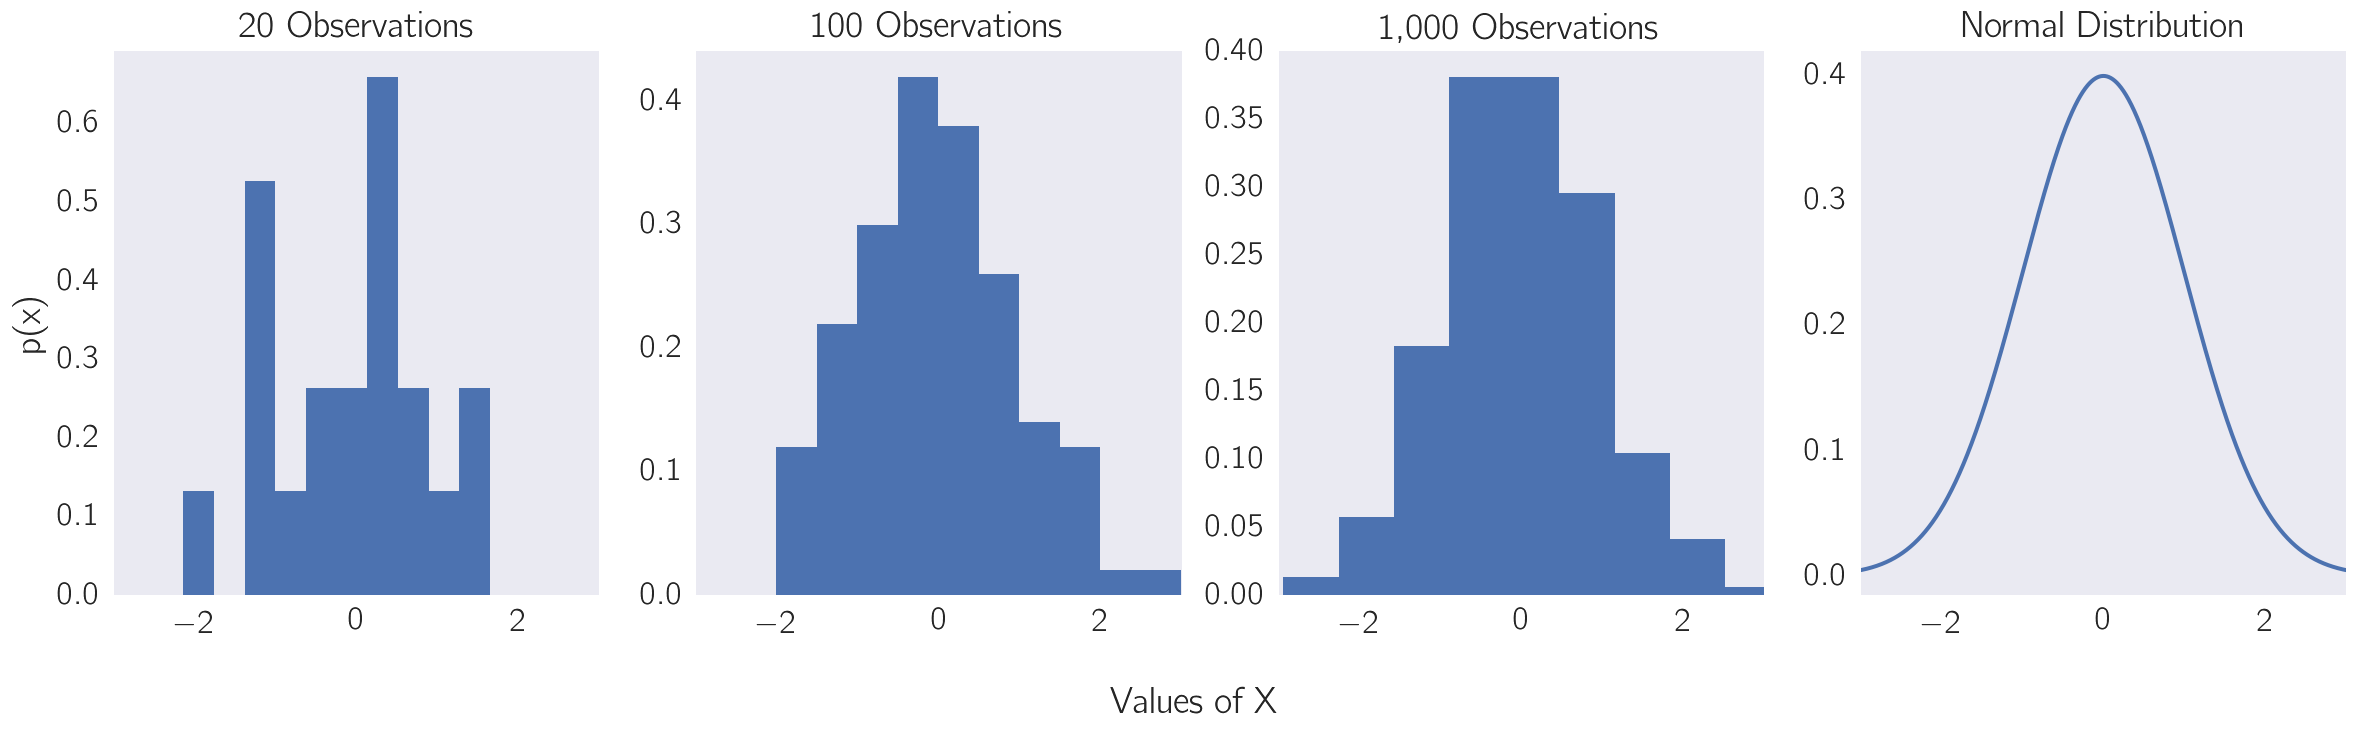

In [11]:
def normal(x):
    return 1/np.sqrt(2*np.pi)*np.exp(-x**2/(2))

x1 = np.random.normal(0, 1, 20)
x2 = np.random.normal(0, 1, 100)
x3 = np.random.normal(0, 1, 1000)
x4 = np.linspace(-3, 3, 1000)

fig, ax = plt.subplots(ncols=4, figsize=(20, 5))
ax[0].hist(x1, normed=True)
ax[0].set_xlim(-3, 3)
ax[0].set_title('20 Observations')

ax[1].hist(x2, normed=True)
ax[1].set_xlim(-3, 3)
ax[1].set_title('100 Observations')

ax[2].hist(x3, normed=True)
ax[2].set_xlim(-3, 3)
ax[2].set_title('1,000 Observations')

ax[3].plot(x4, normal(x4))
ax[3].set_xlim(-3, 3)
ax[3].set_title('Normal Distribution')

ax[0].set_ylabel(r'p(x)')
fig.text(0.5, -0.04, 'Values of X', ha='center', size=18)

Clearly, as more samples are drawn, the better the data approximate the real, underlying distribution. This distribution has some interesting aspects, namely, it has 'tails' that decay quite quickly. Another way to put it is that, if the data are normally distributed, then huge outliers should be rare. 

When we perform line-fitting using the least squares algorithm (as we did above), one of the underlying assumptions is that our data has errors that are normally distributed, and therefore outliers should be very rare. This is why the line of best fit gets strongly skewed by outliers as we saw above: It thinks outliers are common and important!

Is there a way to make outliers less important? Absolutely. We could start by selecting a curve that has tails that decay less quickly than the normal distribution. For example, we could pick a Studen-T distribution!

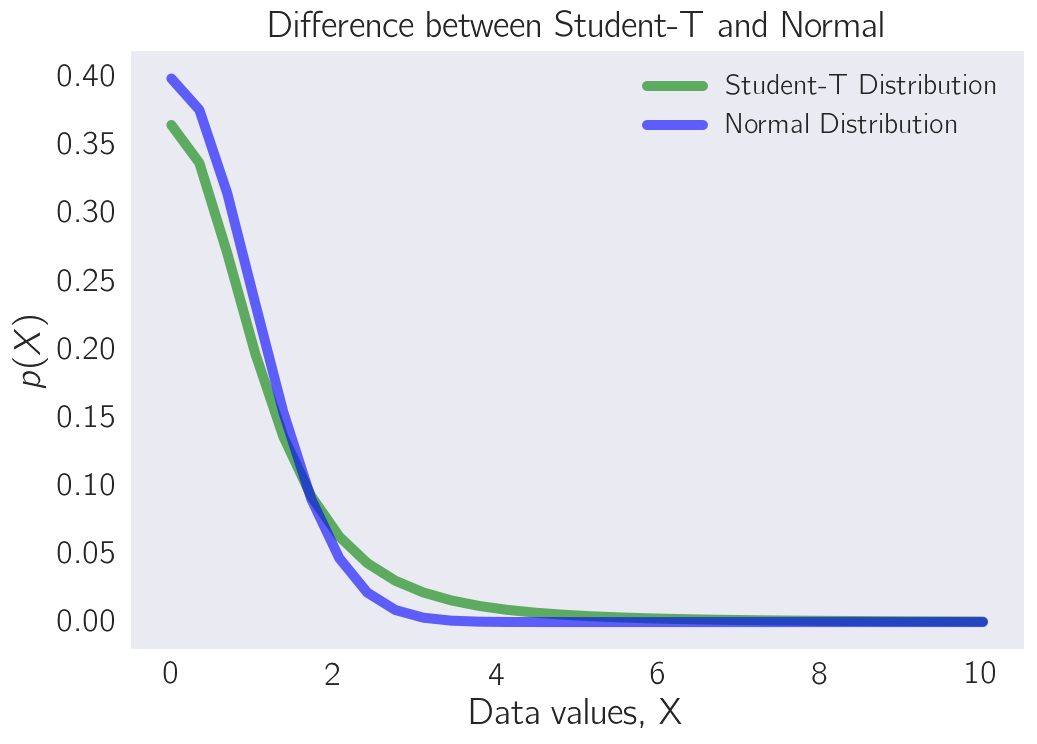

In [12]:
# Points for the normal dist:
xnorm = np.linspace(scipy.stats.norm.ppf(0.01),
                    scipy.stats.norm.ppf(0.99))

# calculate the points for the student t
df = 2.74335149908
t_nums = np.linspace(scipy.stats.t.ppf(0.01, df), 
                scipy.stats.t.ppf(0.99, df), 100)

#plot

plt.plot(x, scipy.stats.t.pdf(x, df), 'g-', lw=5, alpha=0.6, label='Student-T Distribution')
plt.plot(x, scipy.stats.norm.pdf(x), 'b-', lw=5, alpha=0.6, label='Normal Distribution')
plt.legend()
plt.title('Difference between Student-T and Normal')
plt.xlabel('Data values, X')
plt.ylabel('$p(X)$')

Do you see how the green curve is above the blue curve around the edges? Those are the tails of the Student-T distribution decaying more slowly than the Normal distribution. Under a Student-T distribution, the outliers will be far more frequent than under a normal model.

If we want to use a different distribution from the Normal distribution, we will need one last equation. It's called Bayes theorem. Here it is:

$$
P(X|Y) \propto P(Y|X)\cdot P(X)
$$

Read out loud it says: The probability of X happening given that Y is true is proportional to the probability that Y happens given that X is true multiplied by the probability that X is true. 

In other words, what is the probability of rain given that is cloudy? The answer is that it is proportional to the probability of it being cloudy given that it is raining (close to 1) multiplied by the probability of rain (in California, almost 0). Therefore, the probability of rain given that it is cloudy could be very small if you are in California. 

We can appropriate Bayes theorem and use it to model our data as coming from a Student T distribution instead of a Normal distribution. We need Bayes because we need to estimate the distribution that the data will be coming from, since the Student-T depends on certain parameters that are hard to estimate otherwise. 

How do we do this? The details get a bit messy and there's a longer explanation than we can give here, so we won't get into it. The important thing to note is that **by knowing that we need to use a Student-T distribution and that we need to do Bayesian regression we have solved most of the problem**. Some searching quickly reveals that PyMC3 has a module that enables us to do just what we need.

Below, I define a function, with the help of PyMC3 that will allow us to perform linear regression on some of our data. 


In [13]:
def robust_regress(data):
    """
    A robust regression using a StudentT distribution.
    
    Params:
    data - a dictionary with entries called 'x' and 'y'
    
    Outputs:
    trace_robust - the trace of the simulation
    """
    
    # PyMC3 asks you to make an object, called a pm.Model(), so go ahead and make it.
    with pm.Model() as model_robust:
        # Choose your distribution: StudentT
        family = pm.glm.families.StudentT()
        
        # Figure out the model you will fit. In this case, we want y = alpha*x,
        # where alpha is to be determined
        pm.glm.glm('y ~ x', data, family=family)
        
        # PyMC3 performs what we call a Monte Carlo Markov Chain simulation, but this
        # usually only works if we start reasonably close to what alpha should be.
        # Fortunately, PyMC3 can estimate a pretty good starting point using something
        # called a Maximum A Priori likelihood method, so use it!
        start = pm.find_MAP()
        
        # do the simulation and return the results
        step = pm.NUTS(scaling=start)
        trace_robust = pm.sample(2000, step, progressbar=True)
        return trace_robust

Now that we have our robust regression, let's go back to our original data and try to fit a line through it. First, we need to put our data into a dictionary, and then we can run the regression. 

It will take some amount of time, with longer wait times for larger datasets. 

In [14]:
data = dict(x=x, y=y)

trace = robust_regress(data)

Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.5 sec

We fit a linear model, $y = a + bx$, so now we need to extract the parameters:

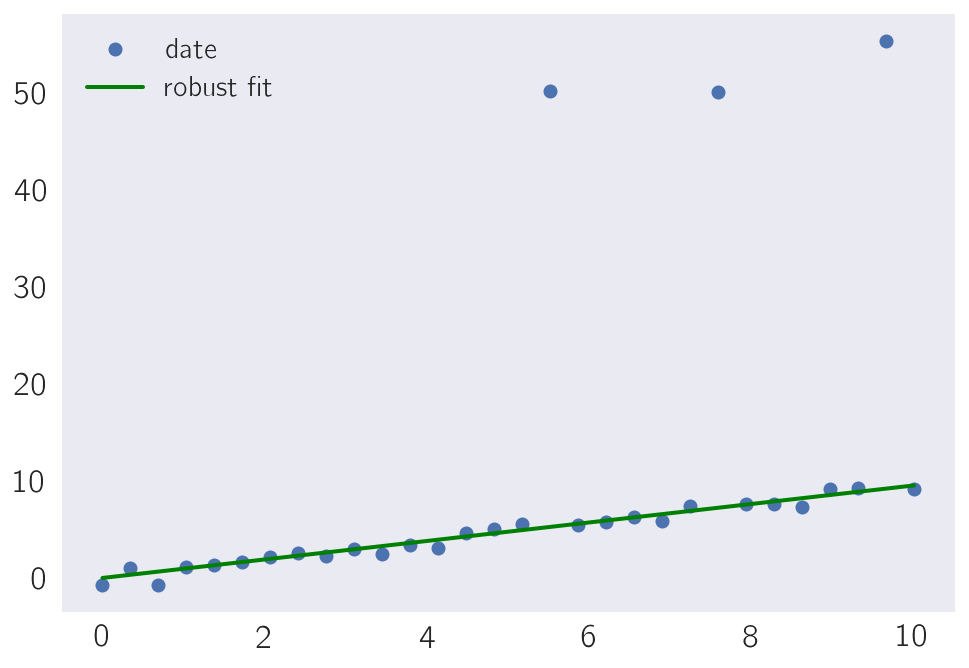

In [15]:
# normalize everything so that all points are centered around 0
intercept = trace.Intercept.mean()
slope = trace.x.mean()

smoothx = np.linspace(0, 10, 1000)

# plot the results
plt.plot(x, y, 'o', label='date')
plt.plot(smoothx, line(smoothx, intercept, slope), 'g-', label='robust fit')
plt.legend()

Perfect!